In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white", context="talk")
pd.set_option('display.max_columns', 500)

from keplergl import KeplerGl
from haversine import haversine, Unit



from datetime import datetime
from datetime import timedelta
import math
import random
import timeit

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import StandardScaler





In [35]:
def read_data(city_name):
    trip_data = pd.read_csv("Project_Data/Combined_Data/"+city_name+".csv", encoding = "ISO-8859-1")
    trip_data["trip_duration"] = pd.to_timedelta(trip_data["trip_duration"])
    trip_data["datetime_start"] = pd.to_datetime(trip_data["datetime_start"])
    trip_data["datetime_end"] = pd.to_datetime(trip_data["datetime_end"])
    trip_data["day"] = pd.to_datetime(trip_data["day"])


    return trip_data




In [3]:
kepler = read_data("duesseldorf")
test = pd.DataFrame(kepler.groupby(kepler["b_number"])["day"].count())
test = test.rename(columns={"day": "#rentals"})
kepler = pd.merge(kepler, test , on="b_number", how='left')
kepler.drop("trip_duration",inplace=True, axis=1)

kepler = kepler[kepler["#rentals"]>50]

bike_list = kepler["b_number"].unique()
radom_sample = random.choice(bike_list)

kepler = kepler[kepler["b_number"]== radom_sample]
kepler = kepler.sort_values(by=["datetime_start"])


kepler.head()



,Unnamed: 0,day,time,b_number,city,orig_lat,orig_lng,dest_lat,dest_lng,datetime_start,datetime_end,weekday,month,hour,week,distance,trip_duration_hours,avg_speed,rounded_time_hourly,temp,wind,rain,fleetsize_weekly,fleetsize_monthly,fleetsize_dayly,#rentals
10385,10385,2019-03-29,13:23:00,31427,duesseldorf,51.247284,6.794717,51.299351,6.732004,2019-03-29 13:23:00,2019-03-29 14:40:00,4,3,13,13,7.249260,1.283333,5.648774,2019-03-29 13:00:00,16.8,2.3,0.0,164,235,66,77
10386,10386,2019-03-29,15:58:00,31427,duesseldorf,51.299187,6.732095,51.243878,6.787126,2019-03-29 15:58:00,2019-03-29 17:06:00,4,3,15,13,7.244232,1.133333,6.391969,2019-03-29 16:00:00,18.2,2.7,0.0,164,235,66,77
10387,10387,2019-03-30,10:40:00,31427,duesseldorf,51.243878,6.787126,51.226700,6.758570,2019-03-30 10:40:00,2019-03-30 11:17:00,5,3,10,13,2.757051,0.616667,4.470893,2019-03-30 11:00:00,16.9,4.7,0.0,164,235,87,77
10388,10388,2019-04-06,12:48:00,31427,duesseldorf,51.233644,6.784490,51.237900,6.789368,2019-04-06 12:48:00,2019-04-06 13:21:00,5,4,12,14,0.582507,0.550000,1.059104,2019-04-06 13:00:00,15.0,3.6,0.0,189,271,59,77
10389,10389,2019-04-06,16:39:00,31427,duesseldorf,51.237900,6.789368,51.218527,6.794867,2019-04-06 16:39:00,2019-04-06 16:54:00,5,4,16,14,2.187956,0.250000,8.751824,2019-04-06 17:00:00,15.9,3.0,0.0,189,271,59,77


In [4]:

rebalancing_trip = kepler
rebalancing_trip = rebalancing_trip.sort_values(by=["datetime_start"])
rebalancing_trip["orig_lat"] = rebalancing_trip["orig_lat"].round(2)
rebalancing_trip["orig_lng"] = rebalancing_trip["orig_lng"].round(2)
rebalancing_trip["dest_lat"] = rebalancing_trip["dest_lat"].round(2)
rebalancing_trip["dest_lng"] = rebalancing_trip["dest_lng"].round(2)

rebalancing_trip = rebalancing_trip[(rebalancing_trip["dest_lat"].shift(1) != rebalancing_trip["orig_lat"])]  

rebalancing_trip

,Unnamed: 0,day,time,b_number,city,orig_lat,orig_lng,dest_lat,dest_lng,datetime_start,datetime_end,weekday,month,hour,week,distance,trip_duration_hours,avg_speed,rounded_time_hourly,temp,wind,rain,fleetsize_weekly,fleetsize_monthly,fleetsize_dayly,#rentals
10385,10385,2019-03-29,13:23:00,31427,duesseldorf,51.25,6.79,51.30,6.73,2019-03-29 13:23:00,2019-03-29 14:40:00,4,3,13,13,7.249260,1.283333,5.648774,2019-03-29 13:00:00,16.8,2.3,0.0,164,235,66,77
10391,10391,2019-04-08,05:34:00,31427,duesseldorf,51.22,6.79,51.25,6.78,2019-04-08 05:34:00,2019-04-08 05:53:00,0,4,5,15,3.883302,0.316667,12.263058,2019-04-08 06:00:00,6.6,0.9,0.0,173,271,69,77
10397,10397,2019-04-16,07:16:00,31427,duesseldorf,51.22,6.77,51.22,6.77,2019-04-16 07:16:00,2019-04-16 07:37:00,1,4,7,16,0.591659,0.350000,1.690453,2019-04-16 07:00:00,8.5,1.6,0.0,205,271,57,77
10399,10399,2019-04-20,14:36:00,31427,duesseldorf,51.24,6.80,51.24,6.82,2019-04-20 14:36:00,2019-04-20 14:56:00,5,4,14,16,1.386647,0.333333,4.159940,2019-04-20 15:00:00,24.4,4.0,0.0,205,271,70,77
10402,10402,2019-05-01,10:24:00,31427,duesseldorf,51.22,6.80,51.22,6.79,2019-05-01 10:24:00,2019-05-01 10:29:00,2,5,10,18,0.537718,0.083333,6.452613,2019-05-01 10:00:00,8.3,1.3,0.0,188,337,71,77
10438,10438,2019-06-14,13:37:00,31427,duesseldorf,51.21,6.78,51.22,6.78,2019-06-14 13:37:00,2019-06-14 13:48:00,4,6,13,24,1.644954,0.183333,8.972475,2019-06-14 14:00:00,25.6,2.6,0.0,412,659,174,77
10443,10443,2019-06-17,14:24:00,31427,duesseldorf,51.22,6.77,51.21,6.77,2019-06-17 14:24:00,2019-06-17 14:54:00,0,6,14,25,1.397915,0.500000,2.795830,2019-06-17 14:00:00,26.0,3.5,0.0,501,659,185,77
10446,10446,2019-06-22,13:46:00,31427,duesseldorf,51.23,6.77,51.26,6.75,2019-06-22 13:46:00,2019-06-22 14:12:00,5,6,13,25,4.021309,0.433333,9.279945,2019-06-22 14:00:00,25.6,4.5,0.0,501,659,208,77
10458,10458,2019-06-30,15:08:00,31427,duesseldorf,51.21,6.78,51.21,6.79,2019-06-30 15:08:00,2019-06-30 15:14:00,6,6,15,26,0.648392,0.100000,6.483916,2019-06-30 15:00:00,29.0,4.9,0.0,538,659,246,77


In [118]:
kepler =read_data("duesseldorf")
kepler["orig_lat"] = kepler["orig_lat"].round(2)
kepler["orig_lng"] = kepler["orig_lng"].round(2)
car2go_E_charging_map = KeplerGl(height=1000)
car2go_E_charging_map.add_data(data=kepler.drop("trip_duration",axis=1),name='duesseldorf')
car2go_E_charging_map


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'duesseldorf': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,…

In [117]:
kepler =read_data("bremen")

car2go_E_charging_map = KeplerGl(height=1000)
car2go_E_charging_map.add_data(data=kepler.drop("trip_duration",axis=1),name='bremen')
car2go_E_charging_map



User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'bremen': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, …

In [7]:
from sklearn.preprocessing import PolynomialFeatures

In [19]:
def plot_Poly_regression(X,Y,d):
    from sklearn.model_selection import train_test_split


    poly_reg = PolynomialFeatures (degree = d)
    
    # Polynomial transformation
    x_poly = poly_reg.fit_transform(X.reshape(-1,1))
    lin_reg_Poly = LinearRegression()
    
    # hold out set
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state=42)


    
    
    # Fitting linear regression to polynomial features
    lin_reg_Poly.fit(x_poly, Y)
    model_pred = lin_reg_Poly.predict(x_poly)
    
    # Plotting the regression line and the data
    x_fit = np.arange(X.min(),X.max() ,1)[:, np.newaxis]
    y_pred = lin_reg_Poly.predict(poly_reg.fit_transform(x_fit.reshape(-1,1)))
    
    plt.scatter(X,Y,marker="x", c='C2')
    ylim = plt.ylim()
    
    plt.plot(x_fit,y_pred, c='C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([X.min()-2,X.max()+2])
    plt.ylim(ylim)
    print ('The R^2 for quadratic curve is: ',r2_score(Y, model_pred))
    print(lin_reg_Poly.coef_)

In [28]:
def lin_regression(X,Y):
    lr = LinearRegression()
    lr.fit(X.reshape(-1,1), Y)
    model_pred_p = lr.predict(X.reshape(-1,1))
    plt.scatter(X, Y, marker="x" )
    plt.xlabel("High Temperature (°C)")
    plt.ylabel("Peak Demand (GW)")
    plt.plot(X, model_pred_p, c='C2')
    print ('The R^2 of linear regression is: ',r2_score(Y, model_pred_p))

In [6]:
Test = read_data("duesseldorf")
Test.head(2)

,Unnamed: 0,day,time,b_number,city,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,datetime_start,datetime_end,weekday,month,hour,week,distance,trip_duration_hours,avg_speed,rounded_time_hourly,temp,wind,rain,fleetsize_weekly,fleetsize_monthly,fleetsize_dayly
0,0,2019-02-06,15:35:00,538,duesseldorf,0 days 00:17:00,51.218927,6.765862,51.240644,6.781982,2019-02-06 15:35:00,2019-02-06 15:52:00,2,2,15,6,2.662958,0.283333,9.398675,2019-02-06 16:00:00,9.5,5.0,0.0,51,131,15
1,1,2019-02-19,15:57:00,538,duesseldorf,0 days 00:23:00,51.213766,6.751624,51.223056,6.779230,2019-02-19 15:57:00,2019-02-19 16:20:00,1,2,15,8,2.182598,0.383333,5.693734,2019-02-19 16:00:00,10.3,5.6,0.0,69,131,16


In [96]:

def set_dataset_absolute(data, X_column, group_by):
    weather = pd.DataFrame()
    weather[X_column] = data.groupby(group_by)[X_column].mean()
    weather["number_ids"]= data.groupby(group_by)["b_number"].count()
    return weather

test = set_dataset_absolute(Test, "temp", "day")

The R^2 of linear regression is:  0.6879473425021476


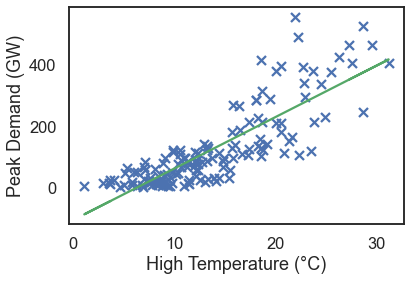

In [37]:
lin_regression(test["temp"].values,test["number_ids"].values)

In [115]:
from haversine import haversine, Unit


def distance_between_coordinates (trip_data, city_center_lat,city_center_lng):
    trip_data["distance_from_center_start"] = trip_data.apply(lambda row: haversine((row["orig_lat"], row["orig_lng"]),(city_center_lat, city_center_lng),Unit.KILOMETERS), axis=1) 
   #X = trip_data.drop(["day","time","b_number","city","trip_duration","orig_lat","orig_lng","dest_lat","dest_lng","avg_speed","rounded_time_hourly","temp","wind","rain","fleetsize_weekly","fleetsize_monthly","fleetsize_dayly","Unnamed: 0","datetime_start","datetime_end","weekday","month","hour","week"], axis=1)
#    X.drop(["distance"],axis=1,inplace=True)
    return trip_data   

In [168]:
test2 = distance_between_coordinates(Test, 51.216429, 6.791910)

In [169]:
test2["distance_from_center_start"] = test2["distance_from_center_start"].apply(np.ceil)

The R^2 for quadratic curve is:  0.7437151142778206
[    0.         -1171.27554113    47.52922078]


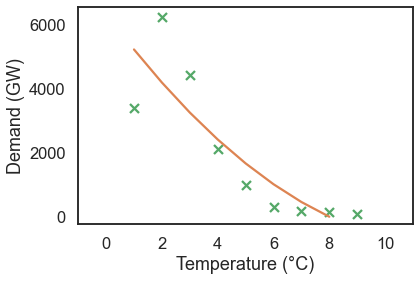

In [170]:
test3 = set_dataset_absolute(test2, "distance_from_center_start", "distance_from_center_start" )
test3 = test3[test3["distance_from_center_start"]<10]

plot_Poly_regression(test3["distance_from_center_start"].values,test3["number_ids"].values,2)

In [121]:


plot_Poly_regression(test["temp"].values,test["number_ids"].values,4)

NameError: name 'plot_Poly_regression' is not defined

,Unnamed: 0,b_number,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,weekday,month,hour,week,distance,trip_duration_hours,avg_speed,temp,wind,rain,fleetsize_weekly,fleetsize_monthly,fleetsize_dayly,distance_from_center_start
count,18038.000000,18038.000000,18038,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000,18038.000000
mean,9018.500000,30615.641091,0 days 00:27:17.556270096,51.225214,6.784543,51.225157,6.784426,3.204734,5.218539,13.373157,21.263555,1.717273,0.454877,5.773809,19.108926,3.954829,0.027692,341.238275,497.056104,135.391063,2.717929
std,5207.266413,6909.397025,0 days 00:32:11.834626498,0.022536,0.023901,0.022143,0.023038,1.986495,1.068599,5.058998,4.771807,1.602547,0.536621,3.558801,7.026636,1.816669,0.311807,149.701612,188.230842,71.743387,2.257239
min,0.000000,538.000000,0 days 00:03:00,50.677853,6.180219,50.677916,6.644770,0.000000,2.000000,0.000000,5.000000,0.000918,0.050000,0.000927,-1.600000,0.300000,0.000000,21.000000,131.000000,3.000000,1.000000
25%,4509.250000,31252.000000,0 days 00:09:00,51.213752,6.775237,51.213752,6.774851,1.000000,5.000000,10.000000,18.000000,0.709099,0.150000,2.877966,14.000000,2.600000,0.000000,205.000000,337.000000,72.000000,2.000000
50%,9018.500000,31359.000000,0 days 00:16:00,51.223149,6.784169,51.223311,6.784123,3.000000,6.000000,14.000000,23.000000,1.378615,0.266667,5.997485,19.300000,3.800000,0.000000,330.000000,659.000000,127.000000,2.000000
75%,13527.750000,31932.000000,0 days 00:28:00,51.236648,6.794867,51.236648,6.794867,5.000000,6.000000,17.000000,25.000000,2.322811,0.466667,8.387293,24.500000,5.100000,0.000000,501.000000,659.000000,201.000000,3.000000
max,18037.000000,53159.000000,0 days 02:59:00,51.523058,7.480777,51.523396,7.480644,6.000000,6.000000,23.000000,26.000000,43.457380,2.983333,24.703928,36.100000,17.600000,8.200000,538.000000,659.000000,257.000000,66.000000


In [1]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


agglo = AgglomerativeClustering(n_clusters=3)
y_pred_agglo = agglo.fit_predict(X_scaled)

plt.figure(figsize=(15,10))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(agglo, labels=agglo.labels_)
plt.ylabel("Distance")
plt.show()

NameError: name 'X_scaled' is not defined

In [83]:
density = read_data("duesseldorf")


In [84]:

density["orig_coordinate"] = list(zip(density["orig_lat"].round(2),density["orig_lng"].round(2)))

In [87]:
desitiy_orig = density.groupby("orig_coordinate").count()

In [91]:
desitiy_orig.sort_values("b_number").reset_index()["b_number"]

0         1
1         1
2         1
3         1
4         1
       ... 
188     932
189     934
190     990
191    1043
192    1232
Name: b_number, Length: 193, dtype: int64

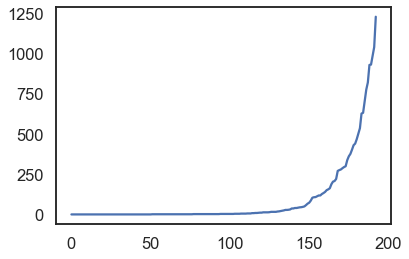

In [92]:
y = desitiy_orig.sort_values("b_number").reset_index()["b_number"]
x = desitiy_orig.sort_values("b_number").reset_index()["b_number"].index
plt.plot(x,y)
plt.show()    

In [122]:
desitiy_orig[desitiy_orig["b_number"]>550].()

Unnamed: 0             10
day                    10
time                   10
b_number               10
city                   10
trip_duration          10
orig_lat               10
orig_lng               10
dest_lat               10
dest_lng               10
datetime_start         10
datetime_end           10
weekday                10
month                  10
hour                   10
week                   10
distance               10
trip_duration_hours    10
avg_speed              10
rounded_time_hourly    10
temp                   10
wind                   10
rain                   10
fleetsize_weekly       10
fleetsize_monthly      10
fleetsize_dayly        10
dtype: int64

In [123]:
desitiy_orig[desitiy_orig["b_number"]<550].count()

Unnamed: 0             183
day                    183
time                   183
b_number               183
city                   183
trip_duration          183
orig_lat               183
orig_lng               183
dest_lat               183
dest_lng               183
datetime_start         183
datetime_end           183
weekday                183
month                  183
hour                   183
week                   183
distance               183
trip_duration_hours    183
avg_speed              183
rounded_time_hourly    183
temp                   183
wind                   183
rain                   183
fleetsize_weekly       183
fleetsize_monthly      183
fleetsize_dayly        183
dtype: int64

In [107]:
desitiy_orig[desitiy_orig["b_number"]>550]

,Unnamed: 0,day,time,b_number,city,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,datetime_start,datetime_end,weekday,month,hour,week,distance,trip_duration_hours,avg_speed,rounded_time_hourly,temp,wind,rain,fleetsize_weekly,fleetsize_monthly,fleetsize_dayly
orig_coordinate,,,,,,,,,,,,,,,,,,,,,,,,,,
"(51.21, 6.78)",990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990,990
"(51.21, 6.79)",934,934,934,934,934,934,934,934,934,934,934,934,934,934,934,934,934,934,934,934,934,934,934,934,934,934
"(51.22, 6.77)",778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778,778
"(51.22, 6.78)",1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043
"(51.22, 6.79)",1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232
"(51.22, 6.8)",629,629,629,629,629,629,629,629,629,629,629,629,629,629,629,629,629,629,629,629,629,629,629,629,629,629
"(51.23, 6.78)",932,932,932,932,932,932,932,932,932,932,932,932,932,932,932,932,932,932,932,932,932,932,932,932,932,932
"(51.24, 6.78)",823,823,823,823,823,823,823,823,823,823,823,823,823,823,823,823,823,823,823,823,823,823,823,823,823,823
"(51.24, 6.79)",705,705,705,705,705,705,705,705,705,705,705,705,705,705,705,705,705,705,705,705,705,705,705,705,705,705


In [63]:
Test = read_data("bremen")
Test2 = Test.drop(["Unnamed: 0","b_number","day","datetime_start","datetime_end","city","fleetsize_monthly","fleetsize_dayly","time","rounded_time_hourly","trip_duration"], axis=1)
Test2

,orig_lat,orig_lng,dest_lat,dest_lng,weekday,month,hour,week,distance,trip_duration_hours,avg_speed,temp,wind,rain,fleetsize_weekly
0,53.078923,8.884911,53.078711,8.899906,6,4,17,16,1.001900,0.216667,4.624155,20.4,2.0,0.0,331
1,53.078923,8.884911,53.078004,8.876828,3,5,15,21,0.549476,0.116667,4.709793,20.7,2.4,0.0,310
2,53.078923,8.884911,53.074731,8.876003,4,6,22,24,0.755886,0.133333,5.669146,19.6,4.4,0.0,304
3,53.074731,8.876003,53.078923,8.884911,6,6,10,24,0.755886,2.033333,0.371747,21.6,3.0,0.0,304
4,53.078923,8.884911,53.076236,8.891322,6,6,12,24,0.522213,2.383333,0.219110,21.8,4.4,0.0,304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57889,53.076722,8.803943,53.067969,8.791199,0,6,21,25,1.293116,0.283333,4.563940,20.9,2.3,0.0,292
57890,53.077387,8.837687,53.079689,8.811892,3,6,5,26,1.741981,0.166667,10.451883,13.7,5.0,0.0,284
57891,53.079729,8.811889,53.062500,8.887222,3,6,5,26,5.385152,0.366667,14.686779,14.5,5.0,0.0,284
57892,53.062500,8.887222,53.071324,8.909244,3,6,15,26,1.768597,0.800000,2.210746,18.3,7.0,0.0,284


,orig_lat,orig_lng,dest_lat,dest_lng,weekday,month,hour,week,distance,trip_duration_hours,avg_speed,temp,wind,rain,fleetsize_weekly
orig_lat,1.000000,-0.070743,0.666620,-0.069857,0.011218,0.013661,0.016450,0.013684,0.098017,0.056897,0.010334,0.031667,0.011423,-0.008008,0.005909
orig_lng,-0.070743,1.000000,-0.066708,0.642663,0.036692,0.029132,0.019055,0.029816,0.050057,0.005220,0.009325,0.024535,-0.004583,-0.004369,0.005283
dest_lat,0.666620,-0.066708,1.000000,-0.072469,0.014842,0.014637,-0.026895,0.014896,0.101439,0.046816,0.018302,0.012958,-0.003795,-0.011474,0.002956
dest_lng,-0.069857,0.642663,-0.072469,1.000000,0.031007,0.026611,0.074545,0.027506,0.067554,0.006757,0.022282,0.042702,0.009909,0.000017,0.006706
weekday,0.011218,0.036692,0.014842,0.031007,1.000000,0.054795,0.017731,0.015008,0.038694,0.069665,-0.054027,0.036468,-0.135769,-0.051645,-0.019903
month,0.013661,0.029132,0.014637,0.026611,0.054795,1.000000,-0.000670,0.976644,0.050110,0.043488,-0.030225,0.686158,-0.082592,0.007820,0.393085
hour,0.016450,0.019055,-0.026895,0.074545,0.017731,-0.000670,1.000000,0.003032,-0.014108,0.008735,-0.045830,0.145488,0.055071,0.010223,-0.000638
week,0.013684,0.029816,0.014896,0.027506,0.015008,0.976644,0.003032,1.000000,0.051888,0.046283,-0.029146,0.722585,-0.110579,-0.006303,0.404185
distance,0.098017,0.050057,0.101439,0.067554,0.038694,0.050110,-0.014108,0.051888,1.000000,0.228120,0.531795,0.046327,-0.049908,-0.026171,0.018980
trip_duration_hours,0.056897,0.005220,0.046816,0.006757,0.069665,0.043488,0.008735,0.046283,0.228120,1.000000,-0.392765,0.110114,0.004391,-0.021441,0.030272


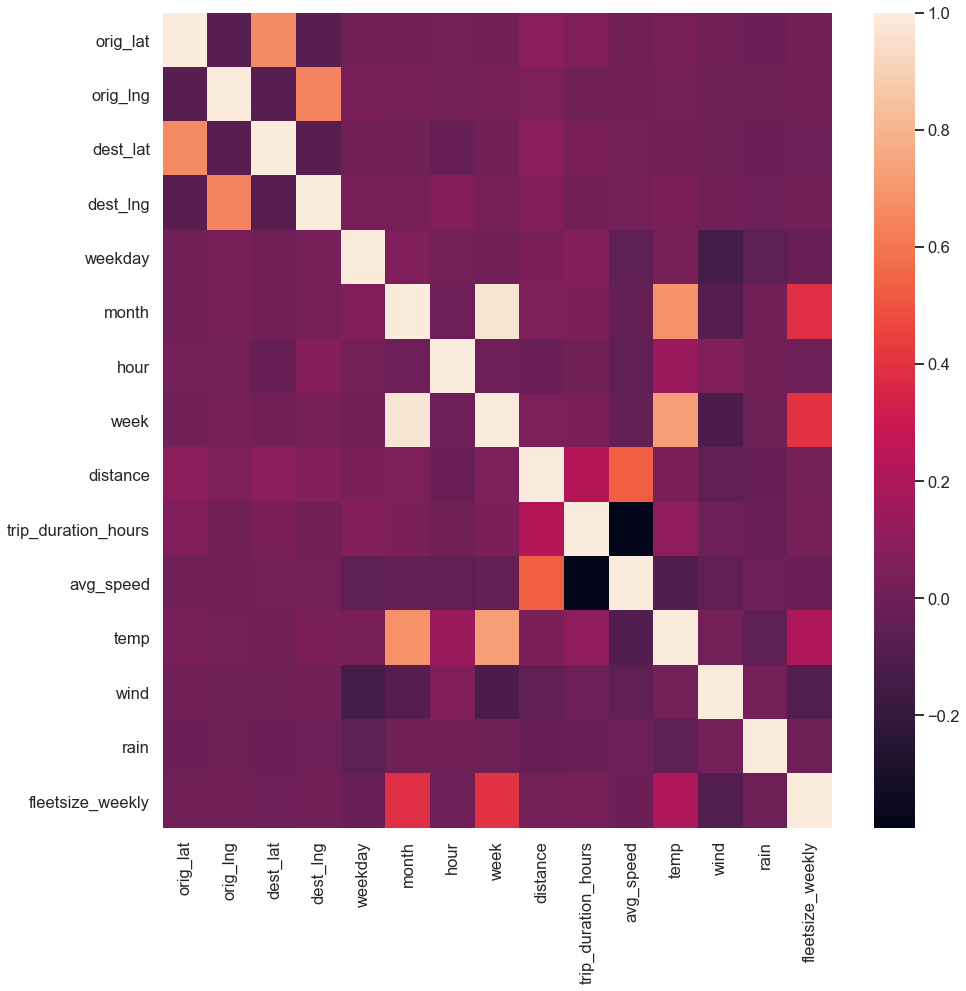

In [64]:
plt.subplots(figsize=(15,15))
corr = Test2.corr()
sns.heatmap(corr)
corr

In [65]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = Test2.columns[columns]
Test2 = Test2[selected_columns]
columns


array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True])

In [58]:
Test2

,orig_lat,orig_lng,dest_lat,dest_lng,weekday,month,hour,distance,trip_duration_hours,avg_speed,temp,wind,rain
0,51.218927,6.765862,51.240644,6.781982,2,2,15,2.662958,0.283333,9.398675,9.5,5.0,0.0
1,51.213766,6.751624,51.223056,6.779230,1,2,15,2.182598,0.383333,5.693734,10.3,5.6,0.0
2,51.229671,6.797855,51.218527,6.794867,4,3,13,1.256486,1.333333,0.942365,19.0,3.5,0.0
3,51.218527,6.794867,51.252515,6.782041,2,3,6,3.883302,0.366667,10.590823,4.8,0.5,0.0
4,51.252515,6.782041,51.242592,6.782100,3,3,14,1.103349,0.200000,5.516746,12.5,1.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18033,51.227590,6.772325,51.226898,6.771832,6,6,20,0.084326,0.700000,0.120466,17.9,3.3,0.0
18034,51.226898,6.771832,51.229461,6.777001,0,6,10,0.459157,0.883333,0.519800,22.6,1.9,0.0
18035,51.229461,6.777001,51.229505,6.776754,0,6,20,0.017920,0.066667,0.268800,17.3,3.2,0.0
18036,51.237900,6.789368,51.222489,6.813165,0,6,12,2.383758,0.316667,7.527656,26.1,2.9,0.0


# PCA

In [82]:

scaler = StandardScaler()
test2_scaled = pd.DataFrame(scaler.fit_transform(Test2))

In [93]:
from sklearn.decomposition import PCA

pca = PCA(n_components=12)
test2_scaled_pca = pca.fit_transform(test2_scaled)

In [94]:
pca.explained_variance_ratio_

array([0.14057648, 0.12920048, 0.11841101, 0.1049351 , 0.08569826,
       0.07942379, 0.07312339, 0.07024471, 0.06156478, 0.05376421,
       0.02534032, 0.02371051])

In [95]:
sum(pca.explained_variance_ratio_)

0.9659930339832872